## Esercizio Classificazione NLP1

<img src="https://doctorvet.it/wp-content/uploads/2020/01/gatto-che-si-gonfia-impaurito.jpg" width="1200">


In [39]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

path = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/NLPes1.csv'

df = pd.read_csv(path)

In [40]:
df

,text,class
0,b'insane ( but inspired ) musical about alferd...,1
1,b'written by david j . schow and john shirley ...,0
2,"b'miramax "" disinvited "" on-line media from pr...",0
3,"b'in "" the astronaut\'s wife , "" charlize ther...",0
4,b'one of the 90s\' most unwelcome thriller tre...,0
...,...,...
408,"b'hav plenty , as we are told in the beginning...",0
409,b'brian de palma\'s snake eyes stars nicolas c...,0
410,b'contact ( pg ) there\'s a moment late in rob...,1
411,"b""this is a film that i was inclined to like a...",0


In [41]:
# STEP1 DEFINIRE ED APPLICARE LA REGEX
import re

patterns = {
    r'\s+': ' ',             # Sostituisce tutti i multipli spazi con uno spazio
    r'\d+': '',              # Rimuove numeri
    r'[^\w\s]': '',          # Rimuove punteggiatura e simboli
    r'\b\w{1,2}\b': '',      # Rimuove tutte le parole con meno di 2 caratteri
    r'(http|www)[^\s]+': '', # Rimuove gli URL
    r'\s+': ' '              # Sostituisce gli spazi multipli con uno spazio (ripetuto, ma necessario per normalizzare)
}

words_to_remove = ['gargamella', 'doggy', 'word3']  # Lista di parole da rimuovere

# Crea un pattern per le parole specifiche da rimuovere
word_pattern = r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b'
patterns[word_pattern] = ''  # Aggiungi il pattern per le parole specifiche

# Funzione per pulire la colonna del DataFrame
def clean_column(df, column, patterns):
    # Assicurati che i valori non stringa vengano trattati come stringhe
    df[column] = df[column].fillna("").astype(str)  # Converti NaN in "" e tutto in stringhe
    
    # Per ogni pattern nel dizionario
    for pattern, replacement in patterns.items():
        # Usa regex=True per assicurarsi che pandas utilizzi regex
        df[column] = df[column].str.replace(pattern, replacement, regex=True)
    
    # Dopo aver fatto tutte le sostituzioni, converte tutto il testo in minuscolo
    df[column] = df[column].str.lower()
    return df

# Assumiamo che tu abbia un DataFrame 'df' e una colonna chiamata 'Text'

# Applica la funzione di pulizia alla colonna 'Text'
df = clean_column(df, 'text', patterns)

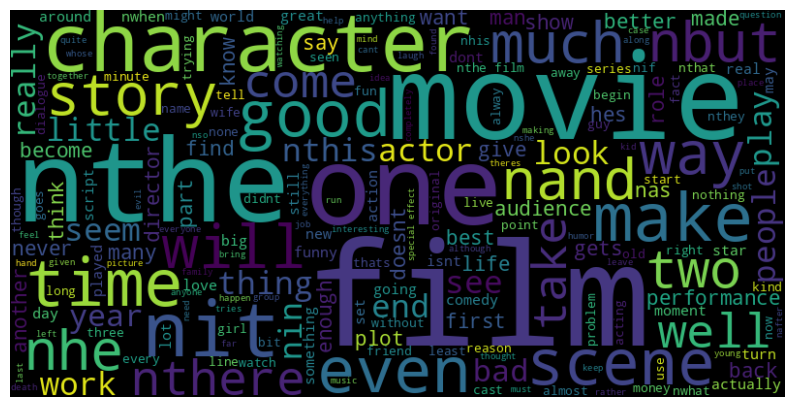

In [42]:
## STEP 2 : EDA con WORDCLOUD
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unisci tutto il testo per creare una sola stringa
all_text = " ".join(df['text'])

# Crea la WordCloud
wordcloud = WordCloud(width=800, height=400).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
##STEP 3: Definizre X e y (features testuali e Target)
X = df['text']
y = df['class'] 

In [44]:
##STEP 4: Vettorizzazione - Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)  # Limita a 1000 parole più frequenti
X_bow = vectorizer.fit_transform(X)

In [45]:
##STEP 5: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [46]:
##STEP 6: Split Training and Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [47]:
##STEP 7: Modellazione
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7469879518072289


In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, patterns):
        self.patterns = patterns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=['text'])
        df = clean_column(df, 'text', self.patterns)
        return df['text'].values

In [49]:
# Step 8: Pipeline Finale (nuovo train test split su dati raw tetuali)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Creazione della pipeline
text_cleaner = TextCleaner(patterns)
bow = CountVectorizer(max_features=15000, stop_words="english")
tfidf = TfidfTransformer()
clf = MultinomialNB(alpha=0.1)

model_pipe = Pipeline([
    ('text cleaner', text_cleaner),  ## Pulizia con regex
    ('bow', bow),                    ## Bag of Words
    ('tfidf', tfidf),                ## TF-IDF
    ('classifier', clf),             ## Classificatore Naive Bayes
])

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.2, random_state=42)

model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)

accuracy = model_pipe.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7590361445783133
